In [1]:
import sys
sys.path.append('../')
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
hyperparams = {
    'learning_rate': 5e-4,  # Control dropout rate
    'patience': 4,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}

num_epochs = 100
print_every = 1

hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 5

In [3]:
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'30oneX': 7,  # 11
    '15oneZ': 8,
    'dennis': 9,
    'trefoil_standard_16': 10,
    'trefoil_optimized': 11

}
knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z',
	'30oneX', '15oneZ', 'dennis',
    'trefoil_standard_16', 'trefoil_optimized'
]
folder = 'data_no_centers_135_13'


num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

Xs_list = []
Ys_list = []
for knot in knots:

    # filename = f'../../../{folder}/data_{knot}_spectr.csv'
    filename = f'../DATA/{folder}/data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            Ys_list.append(knot_types[knot])
            data_array = json.loads(row[0])
            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            Xs_list.append(np.abs(moments.reshape(-1)))


In [4]:
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_torch = torch.tensor(Xs_np).float()
ys_t = torch.tensor(ys_np)
ys_torch = F.one_hot(ys_t.long(), num_classes=num_classes).float()
print(Xs_torch.shape, ys_torch.shape)

torch.Size([12000, 91]) torch.Size([12000, 12])


In [5]:
X_train, X_val_test, y_train, y_val_test = train_test_split(Xs_torch, ys_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [6]:

class ClassifierFC_spec(nn.Module):
    def __init__(self, input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3, num_hidden, num_classes):
        super(ClassifierFC_spec, self).__init__()
        layers = []
        # Create input layer
        layers.append(nn.Linear(input_size, hidden_sizes1, bias=True))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes1, hidden_sizes2, bias=True))
        layers.append(nn.ReLU())
        # Create hidden layers
        for i in range(0, num_hidden):
            layers.append(nn.Linear(hidden_sizes2, hidden_sizes2, bias=True))
            layers.append(nn.ReLU())

        # Create output layer
        layers.append(nn.Linear(hidden_sizes2, hidden_sizes3, bias=True))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes3, num_classes))
        # ModuleList of all layers
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)
        return x

In [7]:
# in_channels, out_channels, kernel_size, stride, padding
input_size = Xs_np.shape[-1]

num_classes = ys_torch.shape[-1]
model = ClassifierFC_spec(input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3,
                          num_hidden, num_classes).to(device)

In [8]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:4][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch).shape)
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([3, 91])
torch.Size([3, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          11,776
              ReLU-2                  [-1, 128]               0
            Linear-3                 [-1, 1024]         132,096
              ReLU-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                 [-1, 1024]       1,049,600
             ReLU-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600

In [9]:
train_dataset[1:2][0]

tensor([[0.0292, 0.0131, 0.0049, 0.0017, 0.0016, 0.0050, 0.0068, 0.0449, 0.0088,
         0.0145, 0.0098, 0.0088, 0.0090, 0.0063, 0.0498, 0.0224, 0.0020, 0.0079,
         0.0077, 0.0038, 0.0007, 0.0084, 0.0223, 0.0254, 0.0117, 0.0117, 0.0166,
         0.0156, 0.0306, 0.0554, 0.0678, 0.0340, 0.0281, 0.0181, 0.0088, 0.1780,
         0.1927, 0.2584, 0.1027, 0.0362, 0.0193, 0.0154, 0.2612, 0.5541, 0.3209,
         0.0732, 0.0125, 0.0174, 0.0139, 0.3275, 0.2071, 0.1263, 0.0387, 0.0202,
         0.0080, 0.0087, 0.3473, 0.0434, 0.0270, 0.0355, 0.0256, 0.0033, 0.0048,
         0.1913, 0.0276, 0.0404, 0.0208, 0.0159, 0.0171, 0.0114, 0.0670, 0.0283,
         0.0375, 0.0152, 0.0166, 0.0141, 0.0092, 0.0382, 0.0420, 0.0481, 0.0221,
         0.0050, 0.0031, 0.0034, 0.0159, 0.0145, 0.0057, 0.0118, 0.0153, 0.0116,
         0.0059]])

In [10]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [11]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)



train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

Progress:   1%|▋                                                                        | 1/100 [00:01<02:26,  1.48s/it]

Epoch 0 completed in 1.48 seconds
Epoch 0: Train Loss: 2.3022, Val Loss: 2.1640


Progress:   2%|█▍                                                                       | 2/100 [00:02<02:14,  1.37s/it]

Epoch 1 completed in 1.29 seconds
Epoch 1: Train Loss: 1.9974, Val Loss: 1.8583


Progress:   3%|██▏                                                                      | 3/100 [00:04<02:08,  1.32s/it]

Epoch 2 completed in 1.27 seconds
Epoch 2: Train Loss: 1.8071, Val Loss: 1.7656


Progress:   4%|██▉                                                                      | 4/100 [00:05<02:05,  1.31s/it]

Epoch 3 completed in 1.28 seconds
Epoch 3: Train Loss: 1.7179, Val Loss: 1.7100


Progress:   5%|███▋                                                                     | 5/100 [00:06<02:03,  1.30s/it]

Epoch 4 completed in 1.30 seconds
Epoch 4: Train Loss: 1.6781, Val Loss: 1.6633


Progress:   6%|████▍                                                                    | 6/100 [00:07<02:02,  1.30s/it]

Epoch 5 completed in 1.30 seconds
Epoch 5: Train Loss: 1.6719, Val Loss: 1.6577


Progress:   7%|█████                                                                    | 7/100 [00:09<02:02,  1.32s/it]

Epoch 6 completed in 1.35 seconds
Epoch 6: Train Loss: 1.6370, Val Loss: 1.6783


Progress:   8%|█████▊                                                                   | 8/100 [00:10<02:00,  1.31s/it]

Epoch 7 completed in 1.30 seconds
Epoch 7: Train Loss: 1.6100, Val Loss: 1.6394


Progress:   9%|██████▌                                                                  | 9/100 [00:11<01:57,  1.29s/it]

Epoch 8 completed in 1.24 seconds
Epoch 8: Train Loss: 1.5985, Val Loss: 1.6275


Progress:  10%|███████▏                                                                | 10/100 [00:13<01:57,  1.30s/it]

Epoch 9 completed in 1.32 seconds
Epoch 9: Train Loss: 1.5650, Val Loss: 1.6204


Progress:  11%|███████▉                                                                | 11/100 [00:14<02:02,  1.38s/it]

Epoch 10 completed in 1.54 seconds
Epoch 10: Train Loss: 1.5329, Val Loss: 1.5507


Progress:  12%|████████▋                                                               | 12/100 [00:16<02:05,  1.43s/it]

Epoch 11 completed in 1.54 seconds
Epoch 11: Train Loss: 1.5178, Val Loss: 1.5780


Progress:  13%|█████████▎                                                              | 13/100 [00:17<02:07,  1.46s/it]

Epoch 12 completed in 1.55 seconds
Epoch 12: Train Loss: 1.4935, Val Loss: 1.5182


Progress:  14%|██████████                                                              | 14/100 [00:19<02:07,  1.49s/it]

Epoch 13 completed in 1.53 seconds
Epoch 13: Train Loss: 1.4279, Val Loss: 1.4967


Progress:  15%|██████████▊                                                             | 15/100 [00:20<02:08,  1.51s/it]

Epoch 14 completed in 1.57 seconds
Epoch 14: Train Loss: 1.4173, Val Loss: 1.4466


Progress:  16%|███████████▌                                                            | 16/100 [00:22<02:08,  1.52s/it]

Epoch 15 completed in 1.55 seconds
Epoch 15: Train Loss: 1.3607, Val Loss: 1.4371


Progress:  17%|████████████▏                                                           | 17/100 [00:23<02:06,  1.52s/it]

Epoch 16 completed in 1.52 seconds
Epoch 16: Train Loss: 1.3167, Val Loss: 1.4015


Progress:  18%|████████████▉                                                           | 18/100 [00:25<02:07,  1.56s/it]

Epoch 17 completed in 1.63 seconds
Epoch 17: Train Loss: 1.2899, Val Loss: 1.3645


Progress:  19%|█████████████▋                                                          | 19/100 [00:27<02:08,  1.59s/it]

Epoch 18 completed in 1.67 seconds
Epoch 18: Train Loss: 1.2730, Val Loss: 1.4570


Progress:  20%|██████████████▍                                                         | 20/100 [00:28<02:10,  1.63s/it]

Epoch 19 completed in 1.71 seconds
Epoch 19: Train Loss: 1.2444, Val Loss: 1.3661


Progress:  21%|███████████████                                                         | 21/100 [00:30<02:08,  1.62s/it]

Epoch 20 completed in 1.61 seconds
Epoch 20: Train Loss: 1.2133, Val Loss: 1.3441


Progress:  22%|███████████████▊                                                        | 22/100 [00:32<02:09,  1.66s/it]

Epoch 21 completed in 1.75 seconds
Epoch 21: Train Loss: 1.1808, Val Loss: 1.3337


Progress:  23%|████████████████▌                                                       | 23/100 [00:34<02:11,  1.71s/it]

Epoch 22 completed in 1.81 seconds
Epoch 22: Train Loss: 1.1606, Val Loss: 1.4445


Progress:  24%|█████████████████▎                                                      | 24/100 [00:35<02:11,  1.74s/it]

Epoch 23 completed in 1.80 seconds
Epoch 23: Train Loss: 1.1465, Val Loss: 1.3875


Progress:  25%|██████████████████                                                      | 25/100 [00:37<02:11,  1.75s/it]

Epoch 24 completed in 1.79 seconds
Epoch 24: Train Loss: 1.1329, Val Loss: 1.3298


Progress:  26%|██████████████████▋                                                     | 26/100 [00:39<02:12,  1.79s/it]

Epoch 25 completed in 1.87 seconds
Epoch 25: Train Loss: 1.1170, Val Loss: 1.3141


Progress:  27%|███████████████████▍                                                    | 27/100 [00:41<02:13,  1.83s/it]

Epoch 26 completed in 1.93 seconds
Epoch 26: Train Loss: 1.0870, Val Loss: 1.3558


Progress:  28%|████████████████████▏                                                   | 28/100 [00:43<02:13,  1.86s/it]

Epoch 27 completed in 1.92 seconds
Epoch 27: Train Loss: 1.0538, Val Loss: 1.3867


Progress:  29%|████████████████████▉                                                   | 29/100 [00:45<02:13,  1.89s/it]

Epoch 28 completed in 1.94 seconds
Epoch 28: Train Loss: 1.0617, Val Loss: 1.2948


Progress:  30%|█████████████████████▌                                                  | 30/100 [00:47<02:13,  1.90s/it]

Epoch 29 completed in 1.94 seconds
Epoch 29: Train Loss: 1.0126, Val Loss: 1.2974


Progress:  31%|██████████████████████▎                                                 | 31/100 [00:49<02:12,  1.92s/it]

Epoch 30 completed in 1.94 seconds
Epoch 30: Train Loss: 1.0000, Val Loss: 1.3837


Progress:  32%|███████████████████████                                                 | 32/100 [00:51<02:10,  1.92s/it]

Epoch 31 completed in 1.94 seconds
Epoch 31: Train Loss: 0.9807, Val Loss: 1.3279


Progress:  33%|███████████████████████▊                                                | 33/100 [00:53<02:06,  1.90s/it]

Epoch 32 completed in 1.83 seconds
Epoch 32: Train Loss: 0.9776, Val Loss: 1.3496


Progress:  34%|████████████████████████▍                                               | 34/100 [00:55<02:06,  1.91s/it]

Epoch 00034: reducing learning rate of group 0 to 1.0000e-04.
Epoch 33 completed in 1.95 seconds
Epoch 33: Train Loss: 0.9387, Val Loss: 1.3997


Progress:  35%|█████████████████████████▏                                              | 35/100 [00:56<02:05,  1.92s/it]

Epoch 34 completed in 1.95 seconds
Epoch 34: Train Loss: 0.7984, Val Loss: 1.4002


Progress:  36%|█████████████████████████▉                                              | 36/100 [00:58<02:03,  1.93s/it]

Epoch 35 completed in 1.93 seconds
Epoch 35: Train Loss: 0.7547, Val Loss: 1.4005


Progress:  37%|██████████████████████████▋                                             | 37/100 [01:00<02:01,  1.93s/it]

Epoch 36 completed in 1.92 seconds
Epoch 36: Train Loss: 0.7285, Val Loss: 1.4842


Progress:  38%|███████████████████████████▎                                            | 38/100 [01:02<01:59,  1.93s/it]

Epoch 37 completed in 1.92 seconds
Epoch 37: Train Loss: 0.7118, Val Loss: 1.4717


Progress:  39%|████████████████████████████                                            | 39/100 [01:04<01:57,  1.93s/it]

Epoch 00039: reducing learning rate of group 0 to 2.0000e-05.
Epoch 38 completed in 1.95 seconds
Epoch 38: Train Loss: 0.6864, Val Loss: 1.5678


Progress:  40%|████████████████████████████▊                                           | 40/100 [01:06<01:55,  1.93s/it]

Epoch 39 completed in 1.93 seconds
Epoch 39: Train Loss: 0.6452, Val Loss: 1.5554


Progress:  41%|█████████████████████████████▌                                          | 41/100 [01:08<01:53,  1.93s/it]

Epoch 40 completed in 1.93 seconds
Epoch 40: Train Loss: 0.6321, Val Loss: 1.5660


Progress:  42%|██████████████████████████████▏                                         | 42/100 [01:10<01:52,  1.93s/it]

Epoch 41 completed in 1.94 seconds
Epoch 41: Train Loss: 0.6271, Val Loss: 1.5905


Progress:  43%|██████████████████████████████▉                                         | 43/100 [01:12<01:50,  1.93s/it]

Epoch 42 completed in 1.93 seconds
Epoch 42: Train Loss: 0.6207, Val Loss: 1.5966


Progress:  44%|███████████████████████████████▋                                        | 44/100 [01:14<01:48,  1.93s/it]

Epoch 00044: reducing learning rate of group 0 to 4.0000e-06.
Epoch 43 completed in 1.92 seconds
Epoch 43: Train Loss: 0.6149, Val Loss: 1.6237


Progress:  45%|████████████████████████████████▍                                       | 45/100 [01:16<01:44,  1.90s/it]

Epoch 44 completed in 1.83 seconds
Epoch 44: Train Loss: 0.6062, Val Loss: 1.6201


Progress:  46%|█████████████████████████████████                                       | 46/100 [01:18<01:43,  1.91s/it]

Epoch 45 completed in 1.93 seconds
Epoch 45: Train Loss: 0.6040, Val Loss: 1.6239


Progress:  47%|█████████████████████████████████▊                                      | 47/100 [01:20<01:41,  1.92s/it]

Epoch 46 completed in 1.95 seconds
Epoch 46: Train Loss: 0.6031, Val Loss: 1.6267


Progress:  48%|██████████████████████████████████▌                                     | 48/100 [01:22<01:40,  1.93s/it]

Epoch 47 completed in 1.94 seconds
Epoch 47: Train Loss: 0.6020, Val Loss: 1.6312


Progress:  49%|███████████████████████████████████▎                                    | 49/100 [01:23<01:38,  1.93s/it]

Epoch 00049: reducing learning rate of group 0 to 8.0000e-07.
Epoch 48 completed in 1.93 seconds
Epoch 48: Train Loss: 0.6004, Val Loss: 1.6400


Progress:  50%|████████████████████████████████████                                    | 50/100 [01:25<01:36,  1.93s/it]

Epoch 49 completed in 1.93 seconds
Epoch 49: Train Loss: 0.5988, Val Loss: 1.6368


Progress:  51%|████████████████████████████████████▋                                   | 51/100 [01:27<01:34,  1.93s/it]

Epoch 50 completed in 1.94 seconds
Epoch 50: Train Loss: 0.5970, Val Loss: 1.6382


Progress:  52%|█████████████████████████████████████▍                                  | 52/100 [01:29<01:33,  1.94s/it]

Epoch 51 completed in 1.96 seconds
Epoch 51: Train Loss: 0.6002, Val Loss: 1.6375


Progress:  53%|██████████████████████████████████████▏                                 | 53/100 [01:31<01:31,  1.94s/it]

Epoch 52 completed in 1.93 seconds
Epoch 52: Train Loss: 0.5968, Val Loss: 1.6382


Progress:  54%|██████████████████████████████████████▉                                 | 54/100 [01:33<01:28,  1.93s/it]

Epoch 00054: reducing learning rate of group 0 to 1.6000e-07.
Epoch 53 completed in 1.93 seconds
Epoch 53: Train Loss: 0.5968, Val Loss: 1.6393


Progress:  55%|███████████████████████████████████████▌                                | 55/100 [01:35<01:26,  1.93s/it]

Epoch 54 completed in 1.92 seconds
Epoch 54: Train Loss: 0.5981, Val Loss: 1.6397


Progress:  56%|████████████████████████████████████████▎                               | 56/100 [01:37<01:25,  1.94s/it]

Epoch 55 completed in 1.94 seconds
Epoch 55: Train Loss: 0.5970, Val Loss: 1.6401


Progress:  57%|█████████████████████████████████████████                               | 57/100 [01:39<01:22,  1.91s/it]

Epoch 56 completed in 1.85 seconds
Epoch 56: Train Loss: 0.5986, Val Loss: 1.6402


Progress:  58%|█████████████████████████████████████████▊                              | 58/100 [01:41<01:20,  1.91s/it]

Epoch 57 completed in 1.92 seconds
Epoch 57: Train Loss: 0.5946, Val Loss: 1.6405


Progress:  59%|██████████████████████████████████████████▍                             | 59/100 [01:43<01:18,  1.92s/it]

Epoch 00059: reducing learning rate of group 0 to 3.2000e-08.
Epoch 58 completed in 1.93 seconds
Epoch 58: Train Loss: 0.5981, Val Loss: 1.6406


Progress:  60%|███████████████████████████████████████████▏                            | 60/100 [01:45<01:16,  1.92s/it]

Epoch 59 completed in 1.92 seconds
Epoch 59: Train Loss: 0.5950, Val Loss: 1.6406


Progress:  61%|███████████████████████████████████████████▉                            | 61/100 [01:47<01:15,  1.92s/it]

Epoch 60 completed in 1.93 seconds
Epoch 60: Train Loss: 0.5957, Val Loss: 1.6407


Progress:  62%|████████████████████████████████████████████▋                           | 62/100 [01:49<01:13,  1.92s/it]

Epoch 61 completed in 1.92 seconds
Epoch 61: Train Loss: 0.5953, Val Loss: 1.6407


Progress:  63%|█████████████████████████████████████████████▎                          | 63/100 [01:50<01:11,  1.93s/it]

Epoch 62 completed in 1.94 seconds
Epoch 62: Train Loss: 0.5971, Val Loss: 1.6407


Progress:  64%|██████████████████████████████████████████████                          | 64/100 [01:52<01:09,  1.93s/it]

Epoch 00064: reducing learning rate of group 0 to 6.4000e-09.
Epoch 63 completed in 1.92 seconds
Epoch 63: Train Loss: 0.5961, Val Loss: 1.6407


Progress:  65%|██████████████████████████████████████████████▊                         | 65/100 [01:54<01:07,  1.93s/it]

Epoch 64 completed in 1.94 seconds
Epoch 64: Train Loss: 0.5976, Val Loss: 1.6407


Progress:  66%|███████████████████████████████████████████████▌                        | 66/100 [01:56<01:05,  1.93s/it]

Epoch 65 completed in 1.93 seconds
Epoch 65: Train Loss: 0.5968, Val Loss: 1.6407


Progress:  67%|████████████████████████████████████████████████▏                       | 67/100 [01:58<01:03,  1.94s/it]

Epoch 66 completed in 1.95 seconds
Epoch 66: Train Loss: 0.5974, Val Loss: 1.6407


Progress:  68%|████████████████████████████████████████████████▉                       | 68/100 [02:00<01:01,  1.94s/it]

Epoch 67 completed in 1.93 seconds
Epoch 67: Train Loss: 0.5974, Val Loss: 1.6408


Progress:  69%|█████████████████████████████████████████████████▋                      | 69/100 [02:02<00:59,  1.92s/it]

Epoch 68 completed in 1.87 seconds
Epoch 68: Train Loss: 0.5951, Val Loss: 1.6408


Progress:  70%|██████████████████████████████████████████████████▍                     | 70/100 [02:04<00:57,  1.92s/it]

Epoch 69 completed in 1.92 seconds
Epoch 69: Train Loss: 0.5960, Val Loss: 1.6408


Progress:  71%|███████████████████████████████████████████████████                     | 71/100 [02:06<00:55,  1.92s/it]

Epoch 70 completed in 1.93 seconds
Epoch 70: Train Loss: 0.5950, Val Loss: 1.6408


Progress:  72%|███████████████████████████████████████████████████▊                    | 72/100 [02:08<00:53,  1.93s/it]

Epoch 71 completed in 1.94 seconds
Epoch 71: Train Loss: 0.5959, Val Loss: 1.6408


Progress:  73%|████████████████████████████████████████████████████▌                   | 73/100 [02:10<00:52,  1.93s/it]

Epoch 72 completed in 1.94 seconds
Epoch 72: Train Loss: 0.5958, Val Loss: 1.6408


Progress:  74%|█████████████████████████████████████████████████████▎                  | 74/100 [02:12<00:50,  1.94s/it]

Epoch 73 completed in 1.96 seconds
Epoch 73: Train Loss: 0.5981, Val Loss: 1.6408


Progress:  75%|██████████████████████████████████████████████████████                  | 75/100 [02:14<00:48,  1.95s/it]

Epoch 74 completed in 1.96 seconds
Epoch 74: Train Loss: 0.5954, Val Loss: 1.6408


Progress:  76%|██████████████████████████████████████████████████████▋                 | 76/100 [02:16<00:46,  1.94s/it]

Epoch 75 completed in 1.92 seconds
Epoch 75: Train Loss: 0.5973, Val Loss: 1.6408


Progress:  77%|███████████████████████████████████████████████████████▍                | 77/100 [02:18<00:44,  1.93s/it]

Epoch 76 completed in 1.92 seconds
Epoch 76: Train Loss: 0.5966, Val Loss: 1.6408


Progress:  78%|████████████████████████████████████████████████████████▏               | 78/100 [02:19<00:42,  1.94s/it]

Epoch 77 completed in 1.95 seconds
Epoch 77: Train Loss: 0.5956, Val Loss: 1.6408


Progress:  79%|████████████████████████████████████████████████████████▉               | 79/100 [02:21<00:40,  1.94s/it]

Epoch 78 completed in 1.94 seconds
Epoch 78: Train Loss: 0.5962, Val Loss: 1.6408


Progress:  80%|█████████████████████████████████████████████████████████▌              | 80/100 [02:23<00:38,  1.94s/it]

Epoch 79 completed in 1.95 seconds
Epoch 79: Train Loss: 0.5991, Val Loss: 1.6408


Progress:  81%|██████████████████████████████████████████████████████████▎             | 81/100 [02:25<00:36,  1.91s/it]

Epoch 80 completed in 1.85 seconds
Epoch 80: Train Loss: 0.5950, Val Loss: 1.6408


Progress:  82%|███████████████████████████████████████████████████████████             | 82/100 [02:27<00:34,  1.92s/it]

Epoch 81 completed in 1.92 seconds
Epoch 81: Train Loss: 0.5959, Val Loss: 1.6408


Progress:  83%|███████████████████████████████████████████████████████████▊            | 83/100 [02:29<00:32,  1.92s/it]

Epoch 82 completed in 1.92 seconds
Epoch 82: Train Loss: 0.5956, Val Loss: 1.6408


Progress:  84%|████████████████████████████████████████████████████████████▍           | 84/100 [02:31<00:30,  1.92s/it]

Epoch 83 completed in 1.94 seconds
Epoch 83: Train Loss: 0.5951, Val Loss: 1.6408


Progress:  85%|█████████████████████████████████████████████████████████████▏          | 85/100 [02:33<00:28,  1.93s/it]

Epoch 84 completed in 1.94 seconds
Epoch 84: Train Loss: 0.5974, Val Loss: 1.6408


Progress:  86%|█████████████████████████████████████████████████████████████▉          | 86/100 [02:35<00:27,  1.93s/it]

Epoch 85 completed in 1.94 seconds
Epoch 85: Train Loss: 0.5977, Val Loss: 1.6408


Progress:  87%|██████████████████████████████████████████████████████████████▋         | 87/100 [02:37<00:25,  1.93s/it]

Epoch 86 completed in 1.93 seconds
Epoch 86: Train Loss: 0.5959, Val Loss: 1.6408


Progress:  88%|███████████████████████████████████████████████████████████████▎        | 88/100 [02:39<00:23,  1.93s/it]

Epoch 87 completed in 1.94 seconds
Epoch 87: Train Loss: 0.5969, Val Loss: 1.6409


Progress:  89%|████████████████████████████████████████████████████████████████        | 89/100 [02:41<00:21,  1.94s/it]

Epoch 88 completed in 1.94 seconds
Epoch 88: Train Loss: 0.6000, Val Loss: 1.6408


Progress:  90%|████████████████████████████████████████████████████████████████▊       | 90/100 [02:43<00:19,  1.93s/it]

Epoch 89 completed in 1.93 seconds
Epoch 89: Train Loss: 0.5966, Val Loss: 1.6409


Progress:  91%|█████████████████████████████████████████████████████████████████▌      | 91/100 [02:45<00:17,  1.94s/it]

Epoch 90 completed in 1.94 seconds
Epoch 90: Train Loss: 0.5981, Val Loss: 1.6409


Progress:  92%|██████████████████████████████████████████████████████████████████▏     | 92/100 [02:46<00:15,  1.93s/it]

Epoch 91 completed in 1.91 seconds
Epoch 91: Train Loss: 0.5964, Val Loss: 1.6409


Progress:  93%|██████████████████████████████████████████████████████████████████▉     | 93/100 [02:48<00:13,  1.93s/it]

Epoch 92 completed in 1.92 seconds
Epoch 92: Train Loss: 0.5960, Val Loss: 1.6409


Progress:  94%|███████████████████████████████████████████████████████████████████▋    | 94/100 [02:50<00:11,  1.92s/it]

Epoch 93 completed in 1.91 seconds
Epoch 93: Train Loss: 0.5968, Val Loss: 1.6409


Progress:  95%|████████████████████████████████████████████████████████████████████▍   | 95/100 [02:52<00:09,  1.93s/it]

Epoch 94 completed in 1.93 seconds
Epoch 94: Train Loss: 0.5971, Val Loss: 1.6409


Progress:  96%|█████████████████████████████████████████████████████████████████████   | 96/100 [02:54<00:07,  1.93s/it]

Epoch 95 completed in 1.93 seconds
Epoch 95: Train Loss: 0.5960, Val Loss: 1.6409


Progress:  97%|█████████████████████████████████████████████████████████████████████▊  | 97/100 [02:56<00:05,  1.93s/it]

Epoch 96 completed in 1.94 seconds
Epoch 96: Train Loss: 0.5945, Val Loss: 1.6409


Progress:  98%|██████████████████████████████████████████████████████████████████████▌ | 98/100 [02:58<00:03,  1.93s/it]

Epoch 97 completed in 1.92 seconds
Epoch 97: Train Loss: 0.5978, Val Loss: 1.6409


Progress:  99%|███████████████████████████████████████████████████████████████████████▎| 99/100 [03:00<00:01,  1.93s/it]

Epoch 98 completed in 1.92 seconds
Epoch 98: Train Loss: 0.5978, Val Loss: 1.6409


Progress: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.82s/it]

Epoch 99 completed in 1.93 seconds
Epoch 99: Train Loss: 0.5965, Val Loss: 1.6409
Total training time: 182.38 seconds


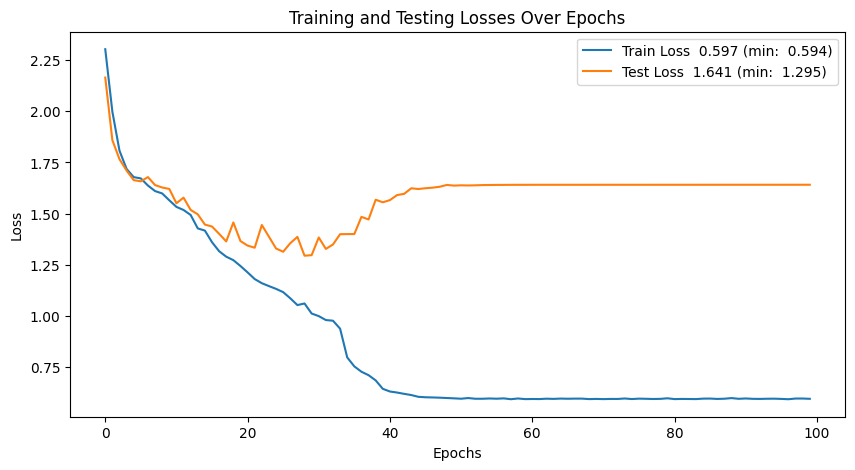

In [12]:
plot_losses(train_losses, val_losses, decimals=3)

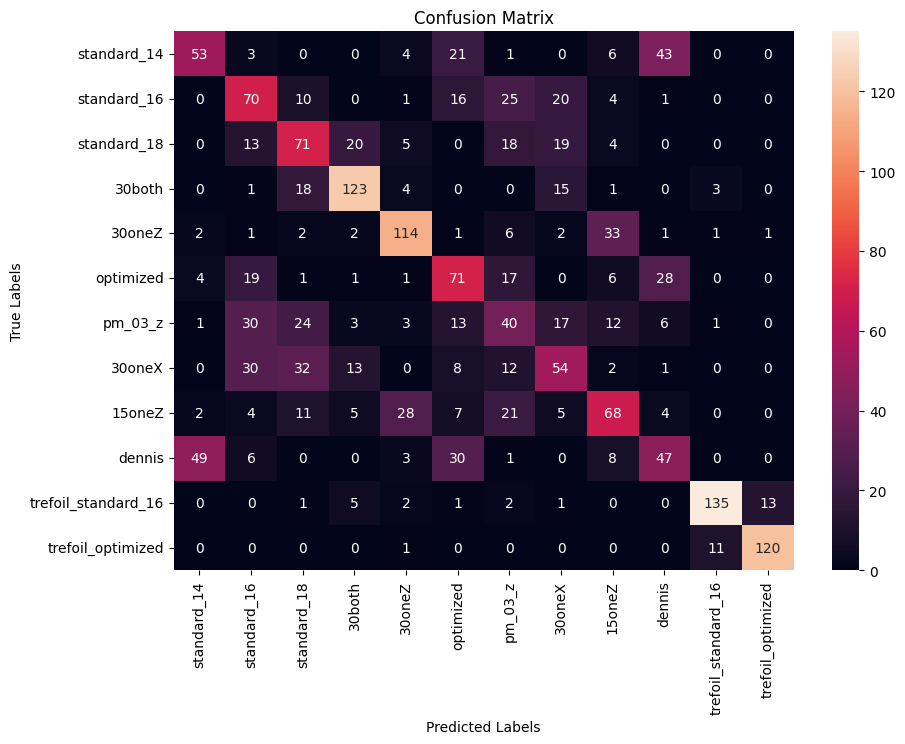

In [13]:
# predictions = model(X_torch.to(device))
# predictions
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.5366666666666666


In [15]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 966/1800
Number of correct predictions (val): 928/1800


Creating the least of the weights in 2D as a basis

In [16]:
def build_weights(weights, ls, ps, l1, l2, p1, p2):
    weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
    for l, p, weight in zip(ls, ps, weights):
        weights_ar[l - l1, p - p1] = weight
    return weights_ar

# getting the dimensions
filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
with open(filename, 'r') as file:
    reader = csv.reader(file)
    row = next(iter(reader))
    data_list = json.loads(row[0])
    # Convert the list back to a NumPy array if needed
    # print(data_list)
    # data_array = np.array(data_list)
    data_array = data_list

    l1, l2 = data_array[0], data_array[1]
    p1, p2 = data_array[2], data_array[3]
print(l1, l2, p1, p2)

values_basis = []
for knot in knots:
# for knot in ['6foil']:
    print(knot)
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:

        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        values = build_weights(weights, ls, ps, l1, l2, p1, p2)
        values = values / np.sqrt(np.sum(np.abs(values) ** 2))
        values_basis.append(values)
        # plt.imshow(np.abs(values).T[::-1])
        # plt.colorbar()
        # plt.show()

print(len(values_basis), values_basis[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '..\\data_no_centers_135_13\\data_standard_14_spectr.csv'

In [ ]:
# Function to calculate MSE
def calculate_mse(array1, array2):
    return ((np.abs(array1) - np.abs(array2)) ** 2).mean()

closest_basis_knots = []
true_labels = []
for knot in knots:
    closest_basis_knot = []
    true_label = []
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            true_label.append(knot_types[knot])
            data_array = json.loads(row[0])

            # indx = data_array[4]
            # field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            # plt.imshow(np.abs(field ))
            # plt.show()

            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))
            mse_scores = [calculate_mse(moments, values) for values in values_basis]
            closest_basis_knot.append(np.argmin(mse_scores))
            # plt.imshow(np.abs(moments))
            # plt.colorbar()
            # plt.show()
    true_labels.append(true_label)
    closest_basis_knots.append(closest_basis_knot)

# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:
predicted_labels_spec_np = np.array(closest_basis_knots).reshape(-1)
true_labels_spec_np = np.array(true_labels).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# def build_weights(weights, ls, ps, l1, l2, p1, p2):
#     weights_ar = np.zeros(((l2 - l1 + 1), (p2 - p1 + 1)), dtype=complex)
#     for l, p, weight in zip(ls, ps, weights):
#         weights_ar[l - l1, p - p1] = weight
#     return weights_ar
#
# # getting the dimensions
# filename = f'..\\{folder}\\data_{knots[0]}_spectr.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     row = next(iter(reader))
#     data_list = json.loads(row[0])
#     # Convert the list back to a NumPy array if needed
#     # print(data_list)
#     # data_array = np.array(data_list)
#     data_array = data_list
#
#     l1, l2 = data_array[0], data_array[1]
#     p1, p2 = data_array[2], data_array[3]
# print(l1, l2, p1, p2)

knots_basis = []
knots_basis_dots = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\data_basis\\data_{knot}.csv'

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]

            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            knots_basis_dots.append(points_list)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            knots_basis.append(dots_3d)

print(len(knots_basis), knots_basis[0].shape)
print(len(knots_basis_dots), knots_basis_dots[0].shape,knots_basis_dots[0][0])
print(knots_basis_dots[0].shape, knots_basis_dots[3].shape)

In [ ]:
# Function to calculate MSE
def calculate_mse_knot(array1, array2):
    return ((array1 - array2) ** 2).mean()

def calculate_mse_knot_dots(array1, dots):
    # loss = -np.sum([np.array(array1)[np.array(dot)] for dot in dots])
    loss = -np.sum([array1[tuple(dot)] for dot in dots])

    return loss

closest_knots = []
closest_knots_dots = []
true_knots = []
j = -1
for i, x in enumerate(X_torch):
    j += 1
    true_knots.append(torch.argmax(y_torch[i]).item())

    mse_scores = [calculate_mse_knot(x[0], knot_) for knot_ in knots_basis]
    closest_knots.append(np.argmin(mse_scores))

    mse_scores_dots = [calculate_mse_knot_dots(x[0], dots_) for dots_ in knots_basis_dots]
    # print(mse_scores_dots)
    # min_indices = np.where(mse_scores_dots == np.min(mse_scores_dots))[0]
    # if len(min_indices) > 1:
    #     result = 0
    # else:
    #     result = min_indices[0]
    closest_knots_dots.append(np.argmin(mse_scores_dots))
    # plt.imshow(knots_basis[j][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(x[0][:, :, 8])
    # plt.colorbar()
    # plt.show()
    # break


# print(len(closest_basis_knots), len(closest_basis_knots[0]), print(closest_basis_knots[0]))
# print(true_labels)
# print(closest_basis_knots)


In [ ]:

predicted_labels_spec_np = np.array(closest_knots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

predicted_labels_spec_np = np.array(closest_knots_dots).reshape(-1)
true_labels_spec_np = np.array(true_knots).reshape(-1)
# print(true_labels_spec_np)
cm = confusion_matrix(true_labels_spec_np, predicted_labels_spec_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:


X_list_sp = []
Y_list_sp = []
for knot in knots:
# for knot in ['6foil']:
    filename = f'..\\{folder}\\data_{knot}_spectr.csv'
    with open(f'..\\{folder}\\{knot}.pkl', 'rb') as file:
        file = pickle.load(file)
        ls = file['l']
        ps = file['p']
        weights = file['weight']
        for row in reader:
                # Deserialize the JSON string back to a list
                data_list = json.loads(row[0])
                # Convert the list back to a NumPy array if needed
                # print(data_list)
                # data_array = np.array(data_list)
                data_array = data_list

                l1, l2 = data_array[0], data_array[1]
                p1, p2 = data_array[2], data_array[3]

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            # print(data_list)
            # data_array = np.array(data_list)
            data_array = data_list

            l1, l2 = data_array[0], data_array[1]
            p1, p2 = data_array[2], data_array[3]
            indx = data_array[4]
            field = np.load(f'..\\{folder}\\fields\\data_{knot}_{indx}.npy')
            plt.imshow(np.abs(field ))
            plt.show()

            # print(f'l1, l2, p1, p2: {l1}, {l2}, {p1}, {p2} ({(l2 - l1 + 1) * (p2 - p1 + 1)})')
            # moments = np.array(data_array[4:]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]]).reshape((l2 - l1 + 1), (p2 - p1 + 1))
            # plt.imshow(np.abs(moments).T[::-1, :])
            # plt.show()
            values = build_weights(weights, ls, ps, l1, l2, p1, p2)
            print(f"{knot}")
            plt.imshow(np.abs(values))
            plt.colorbar()
            plt.show()
            plt.imshow(np.abs(moments))
            plt.colorbar()
            plt.show()
            # plt.imshow(np.real(moments).T[::-1, :])
            # plt.show()
            print(moments)
            break
            # continue
            # points_list = data_array[2:]
            # Nx, Ny, Nz = data_array[1]
            # if desired_res != (Nx, Ny, Nz):
            #     scale_x = desired_res[0] / Nx
            #     scale_y = desired_res[1] / Ny
            #     scale_z = desired_res[2] / Nz
            #     points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # # Initialize a 3D array with zeros
            # dots_3d = np.zeros(desired_res, dtype=int)
            # # Set the specified coordinates to 1
            # for x, y, z in points_list:
            #     try: dots_3d[x, y, z] = 1
            #     except IndexError: continue
            # X_list.append(dots_3d)
            # # X_list.append(data_array)
            # Y_list.append(knot_types[knot])
    break

In [ ]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)